In [80]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from line_profiler import LineProfiler

import gaez_data_loader
import simulation
import toolbox
import importlib
importlib.reload(simulation)
importlib.reload(toolbox)
importlib.reload(gaez_data_loader)

<module 'gaez_data_loader' from 'C:\\Users\\leoko\\PycharmProjects\\pythonProject\\gaez_data_loader.py'>


 Distance matrix has shape  (200, 200, 200) 
 Window of Interest has columns and rows  200 200


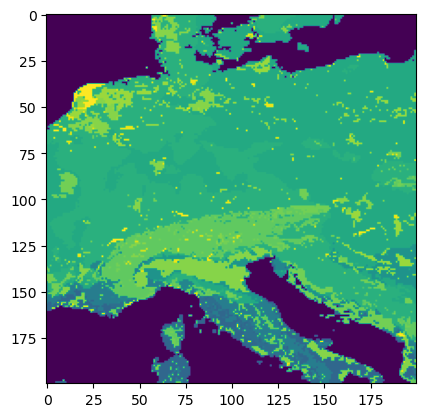

In [81]:
# Load GAEZ data

data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "aez_33_classes_low_res.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=False)
gaez_data.set_woi(r0=400, c0=2200, n_rows=200, n_cols=200) # crop europe
gaez_data.get_distance_matrix(verbose=True) # load distance matrix

test_data = np.copy(gaez_data._array)

plt.imshow(test_data) # visualize

In [86]:
# Parameters
num_rows, num_cols = 20, 20
num_vars = 2 # number of env. variables
p_0 = 800 # Basic productivity - sets max. population for a single village
pop_min, pop_max = 10, 20 # Min and max population for a village to split

# Updating the population dynamics
sim_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - denotes time

# If too small, population will overshoot and array will get clipped.
# For an env. vector of length N, the worst prod. is zero, and the next-worst prod. is 1 / N
# So a reasonable setting is 1 / (4 * N) * p_0 imo
# p_min = 1 / (8 * num_vars) * p_0
p_min = 0 # If None, population gets clipped to zero in each update of the logistic ODE

# Single lattice with seed 50
lattice = simulation.Lattice(n_rows=num_rows, n_cols=num_cols, steps_sim=sim_steps, seed=50, idx_start=(12, 10),
                             num_env_vars=num_vars, pop_min=pop_min, pop_max=pop_max, env=None,
                             rate_growth=rate, prod_min=p_min, rate_prod=p_0)

In Lattice.init().: To avoid negative population, clip population to zero.
Cell productivity varies in steps 400. In case of GAEZ env., this is also the maximum productivity.


In [87]:
# Load GAEZ instance to lattice class
# lattice.load_gaez_instance(gaez_data)

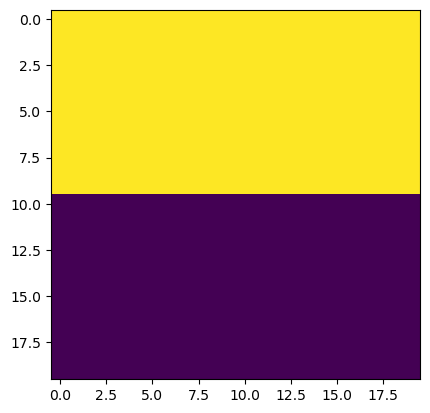

In [88]:
# Add custom environment to check limits of simulation
test_env = np.zeros_like(lattice.env)

test_env[:10, :, 0] = 1
test_env[10:, :, 0] = 0
test_env[:10, :, 1] = 0
test_env[10:, :, 1] = 1

plt.imshow(test_env[:, :, 0])

# adapt lattice p_in - 400 is max. productivity and varies in steps of 400
lattice.pop_max, lattice.pop_min = 100, 300
lattice.env = test_env

In [89]:
print(lattice.env[lattice.r0, lattice.c0]) # check environment at start location
print(lattice.skills[lattice.r0, lattice.c0]) # check skill at start location

lattice.skills[lattice.r0, lattice.c0] = [0, 1]
print(lattice.skills[lattice.r0, lattice.c0]) # check skill at start location

[0. 1.]
[1. 1.]
[0. 1.]


In [97]:
print(lattice.indices_r)

[-2 -1 -1 -1  0  0  0  0  1  1  1  2]


In [90]:
# Run with line profiler
profiler_line = LineProfiler()
profiler_line.enable_by_count()
profiler_line.add_function(lattice.migrate_to)

lattice.set_search_params(prod_threshold=1, neigh_type="von_neumann", distance=2,
                          search_intelligently=True, max_distance_km=None)
lattice.set_evolution_params(env_mutation_rate=None, skill_mutation_rate=0.01, mutation_method="4_rates",
                             repopulate_empty_cells=True, metropolis_scale=10)
# check = []
# for _ in tqdm(range(1_000)):
#      lattice.move_forward()
#      lattice.num_iter += 1
#      check.append(lattice.skills[lattice.r0, lattice.c0])

lattice.run(disable_progress_bar=False, track_skill_start=True)

profiler_line.print_stats()

100%|██████████| 4999/4999 [00:24<00:00, 206.78it/s]

Timer unit: 1e-07 s

Total time: 18.8065 s
File: C:\Users\leoko\PycharmProjects\pythonProject\simulation.py
Function: migrate_to at line 331

Line #      Hits         Time  Per Hit   % Time  Line Contents
   331                                               def migrate_to(self, idx_r, idx_c, search_empty_cells=True):
   332                                                   """ This is the core loop that is intended for NUMBA to vastly speed up the FOR loop.
   333                                                   Loops through occupied cells, selects a migration location for each cell based on a prob. distribution."""
   334                                           
   335                                                   # Loop through non-zero cells
   336    415342    2439401.0      5.9      1.3          for rr, cc in zip(idx_r, idx_c):
   337    415342    9064060.0     21.8      4.8              candidates_r = self.indices_r + rr  # get index mask
   338    415342    6888904.0    

In [93]:
print(lattice.env[lattice.r0, lattice.c0])

print(lattice.skill_array[1400])

[0. 1.]
[0. 1.]


Text(0.5, 1.0, 'Useful skill')

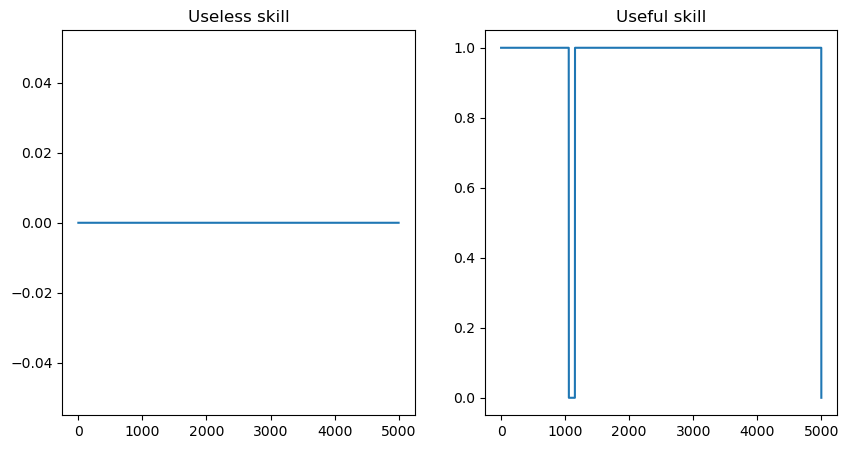

In [94]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(lattice.skill_array[:,  0])
ax1.set_title("Useless skill")

ax2.plot(lattice.skill_array[:, 1])
ax2.set_title("Useful skill")

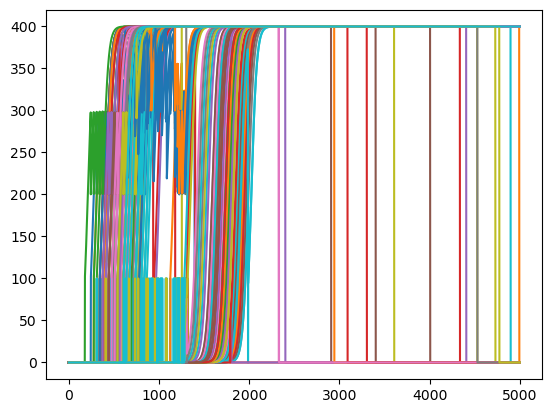

In [95]:
# Plot population of different cells
fig = plt.figure() # no NAN values

to_plot = lattice.population
for ii in range(10):
    plt.plot(to_plot[:, :, ii])

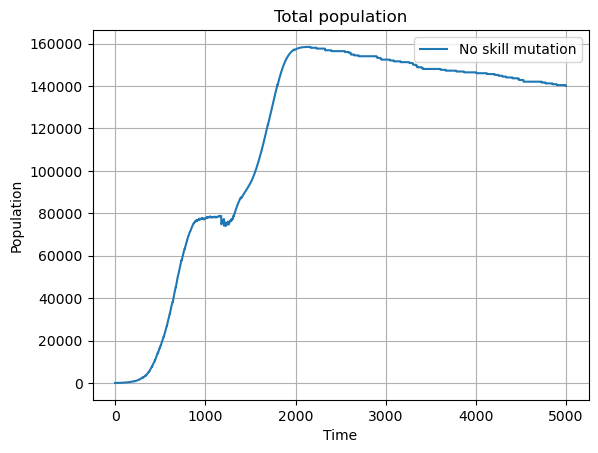

In [96]:
# Get entire population
fig = plt.figure()

pop_t = lattice.population

pop_t[np.isnan(pop_t)] = 0 # to clean for NaN values
pop_total = np.sum(pop_t, axis=(1, 2))

plt.plot(pop_total[:-1], label="No skill mutation")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")
plt.legend()

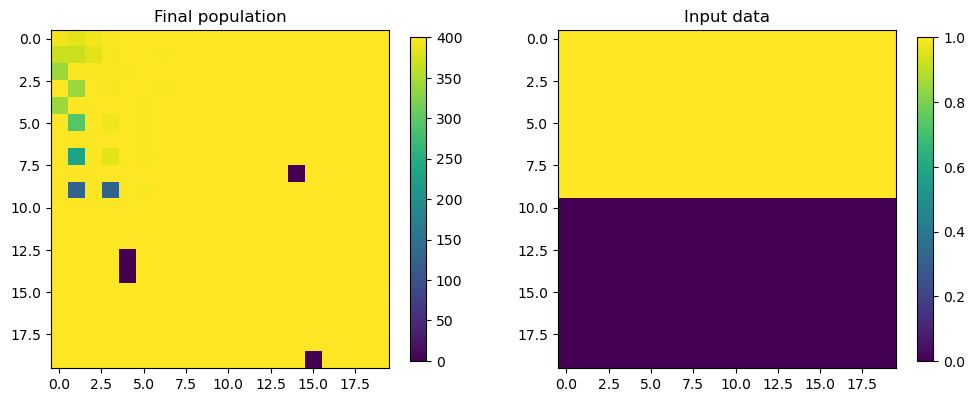

In [99]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.population[2000, :, :])
ax1.set_title("Final population")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(test_env[:, :, 0])
ax2.set_title("Input data")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

[0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]


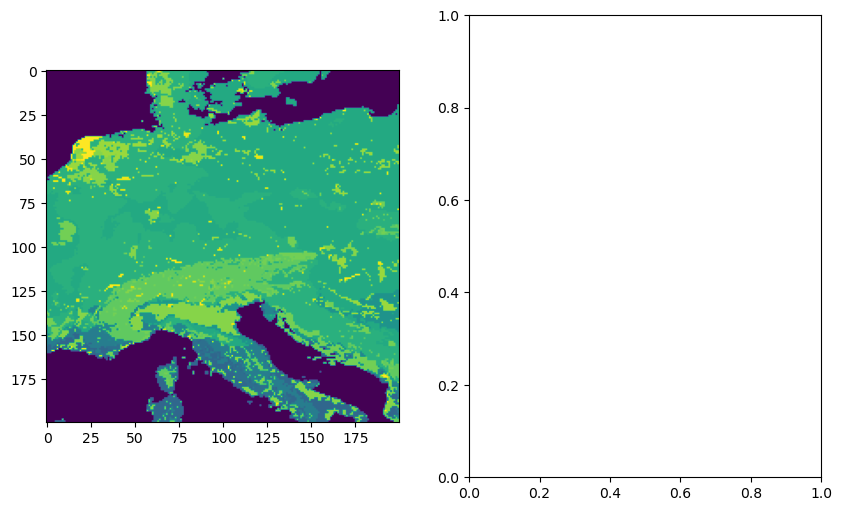

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

# plot different skills
skills_plot = np.copy(lattice.skills)

# print(skills_plot[100, 100, :])
#  = np.argwhere(skills_plot != 0, axis=3)
# scaling_factors.reshape((200, 200))

ax1.imshow(test_data)
# ax2.imshow(lattice.ski)